<a href="https://colab.research.google.com/github/ketangunjal22/HousePricePrediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Data Preparation

In [150]:
# Importing Packages
import pandas as pd
import numpy as np
import datetime
import scipy.stats as stats
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [151]:
# read data
df = pd.read_csv(r"/content/sample_dataset.csv")
df.head()

,ID,OverallQual,GrLivArea,YearBuilt,TotalBsmtSF,FullBath,HalfBath,GarageCars,GarageArea,SalePrice
0,1,5,629,2022,702,1,0,3,627,457528
1,2,2,2402,1972,251,1,1,3,705,78691
2,3,7,1547,1968,1224,3,0,1,282,316056
3,4,1,666,1937,2890,4,1,3,39,213285
4,5,9,2946,1985,768,2,1,4,848,304717


In [152]:
df.shape

(1000, 10)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           1000 non-null   int64
 1   OverallQual  1000 non-null   int64
 2   GrLivArea    1000 non-null   int64
 3   YearBuilt    1000 non-null   int64
 4   TotalBsmtSF  1000 non-null   int64
 5   FullBath     1000 non-null   int64
 6   HalfBath     1000 non-null   int64
 7   GarageCars   1000 non-null   int64
 8   GarageArea   1000 non-null   int64
 9   SalePrice    1000 non-null   int64
dtypes: int64(10)
memory usage: 78.2 KB


In [154]:
df.isna().sum()

ID             0
OverallQual    0
GrLivArea      0
YearBuilt      0
TotalBsmtSF    0
FullBath       0
HalfBath       0
GarageCars     0
GarageArea     0
SalePrice      0
dtype: int64

In [156]:
df.columns

Index(['ID', 'OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF',
       'FullBath', 'HalfBath', 'GarageCars', 'GarageArea', 'SalePrice'],
      dtype='object')

In [157]:
df.tail()

,ID,OverallQual,GrLivArea,YearBuilt,TotalBsmtSF,FullBath,HalfBath,GarageCars,GarageArea,SalePrice
995,996,2,863,1947,1381,4,1,4,58,258966
996,997,8,1392,1963,203,2,0,1,553,348957
997,998,2,921,2005,1705,3,0,0,600,233760
998,999,8,3252,1930,3016,4,2,4,203,394155
999,1000,9,3336,1953,1961,2,0,2,26,214000


In [158]:
df['ID']

0         1
1         2
2         3
3         4
4         5
       ... 
995     996
996     997
997     998
998     999
999    1000
Name: ID, Length: 1000, dtype: int64

In [159]:
df = df.drop('ID', axis = 1)                 #ID column dropped

In [160]:
df['OverallQual'].value_counts()             #looks like it is ordinal quality rating or score, so we will keep as it is.

OverallQual
7     120
10    117
2     109
9     100
1      99
4      96
5      95
6      93
8      92
3      79
Name: count, dtype: int64

In [161]:
df['GrLivArea'].max()                        #we are assuming that this feature is Ground Living Area, it is indicating sqft area so we are keeping as it is.

3499

In [162]:
df['GrLivArea'].mean()

1996.309

In [163]:
df['YearBuilt'].value_counts()

YearBuilt
1971    18
2008    16
1901    15
1950    15
1972    15
        ..
1904     3
1986     3
1952     3
1906     3
1992     2
Name: count, Length: 123, dtype: int64

In [164]:
# Rename column 'YearBuilt' to 'HouseAge'
df.rename(columns={'YearBuilt': 'HouseAge'}, inplace=True)

In [165]:
#function to convert year of built to age of house.
def Age(n):
    return datetime.datetime.now().year - n

#apply function to feature
df['HouseAge'] = df['HouseAge'].apply(Age)

In [166]:
df['TotalBsmtSF']                      #we are assuming that this feature is Total basement sqft, it is indicating sqft area so we are keeping as it is.

0       702
1       251
2      1224
3      2890
4       768
       ... 
995    1381
996     203
997    1705
998    3016
999    1961
Name: TotalBsmtSF, Length: 1000, dtype: int64

In [167]:
df['FullBath'].value_counts()

FullBath
4    262
1    257
2    242
3    239
Name: count, dtype: int64

In [168]:
df['HalfBath'].value_counts()

HalfBath
1    346
0    330
2    324
Name: count, dtype: int64

In [169]:
# Will check Relation between GarageCars & GarageArea. if its positive then we will try to drop one feature if possible.
# Group the DataFrame by the 'GarageCars' and iterate over each group
grouped_data = df.groupby('GarageCars')

# Extract the 'GarageArea' values from each group and passed them to f_oneway
f_statistic, p_value = stats.f_oneway(*[group[1]['GarageArea'] for group in grouped_data])
print("P-value:", p_value)

P-value: 0.7776687598674474


High P-value suggest that there is no relation between the categorical variable and the continuous variable based on this test.
so we will consider no similarity between both variables. and will treat them differently.

In [171]:
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

In [172]:
# testing the shape of splitted data.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 8)
(200, 8)
(800,)
(200,)


# 2. Model Training

In [173]:
# Initialize the linear regression model
linear_reg = LinearRegression()

# Fit the model on the training data
linear_reg.fit(X_train, y_train)

# Predict on the testing data
y_pred = linear_reg.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Score:", r2)

Mean Absolute Error (MAE): 108993.60946653158
Root Mean Squared Error (RMSE): 126669.95943662085
R-squared (R2) Score: 0.00045454878750061933


<Axes: xlabel='SalePrice', ylabel='Count'>

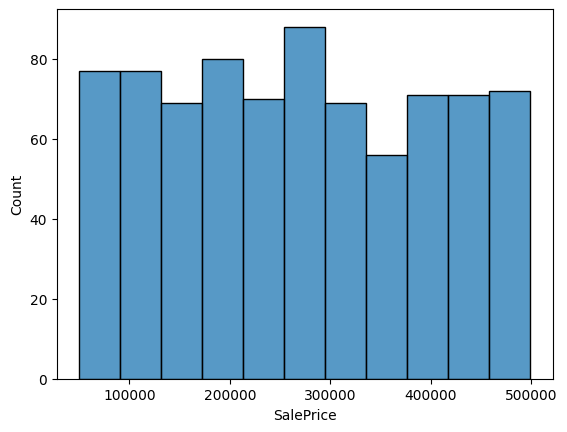

In [175]:
# plotting the actual & predicted data to get insights of it.
sns.histplot(y_train)

<Axes: ylabel='Count'>

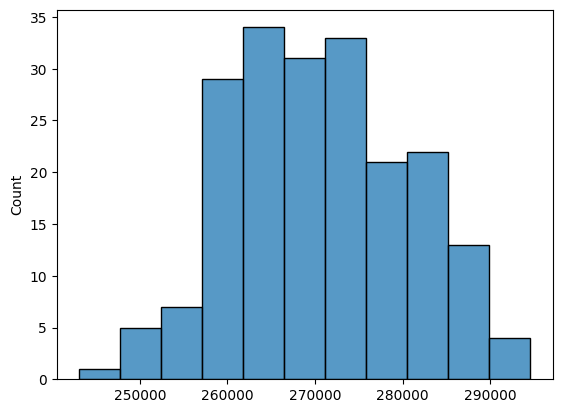

In [176]:
sns.histplot(y_pred)

In [177]:
df.corr()['SalePrice']

OverallQual   -0.023987
GrLivArea     -0.022882
HouseAge       0.004240
TotalBsmtSF    0.031701
FullBath       0.009416
HalfBath      -0.009761
GarageCars     0.024781
GarageArea    -0.051827
SalePrice      1.000000
Name: SalePrice, dtype: float64

In [ ]:
# Group SalePrice by the levels of FullBath
groups = [df['SalePrice'][df['FullBath'] == level] for level in df['FullBath'].unique()]

# Perform ANOVA
f_statistic, p_value = f_oneway(*groups)

# Print the results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

There is no correlation between all independent variable with dependent variable.

In [179]:
# Initialize the decision tree regressor
decision_tree_reg = DecisionTreeRegressor(random_state=22)

# Fit the model on the training data
decision_tree_reg.fit(X_train, y_train)

# Predict on the testing data
y_pred = decision_tree_reg.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Score:", r2)

Mean Absolute Error (MAE): 157101.62
Root Mean Squared Error (RMSE): 190317.09893115226
R-squared (R2) Score: -1.2563730406763


In [180]:
# Initialize the random forest regressor
random_forest_reg = RandomForestRegressor(random_state=22)

# Fit the model on the training data
random_forest_reg.fit(X_train, y_train)

# Predict on the testing data
y_pred = random_forest_reg.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Score:", r2)

Mean Absolute Error (MAE): 114389.80125
Root Mean Squared Error (RMSE): 132780.32685331328
R-squared (R2) Score: -0.09830446936012982


Data is non linear, so using Polynomial Regression to find non-linearity in the data with polynomial function.

In [182]:
# Polynomial features
degree = 2  # Choose the degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

# Fit polynomial regression model
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)

# Predictions
y_pred = poly_reg.predict(X_poly)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE for polynomial regression:", rmse)

RMSE for polynomial regression: 166985.35623687576


Not getting satisfying result so trying with scaled down values and checking with Distance based algorithms

In [184]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [185]:
# Initialize the KNN regressor
knn_reg = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data
knn_reg.fit(X_train_scaled, y_train)

# Predict on the testing data
y_pred = knn_reg.predict(X_test_scaled)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE) for KNN regression:", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE) for KNN regression:", rmse)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Score for KNN regression:", r2)

Mean Absolute Error (MAE) for KNN regression: 112335.23399999998
Root Mean Squared Error (RMSE) for KNN regression: 132856.7119545234
R-squared (R2) Score for KNN regression: -0.09956848536456264


In [189]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score

# Define custom R-squared loss function
def r_squared_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    y_pred = tf.cast(y_pred, tf.float32)  # Cast y_pred to float32
    r2 = 1 - tf.reduce_sum(tf.square(y_true - y_pred)) / tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return -r2

# Define the ANN model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=r_squared_loss)

# Train the model without printing epochs
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model on the test data
y_pred = model.predict(X_test_scaled)
y_pred = tf.squeeze(y_pred)  # Remove any unnecessary dimensions
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Score on Test Data:", r2)

7/7 [==============================] - 0s 2ms/step
R-squared (R2) Score on Test Data: -1.4340346823703567


#3.Explaination

1.   Did data processing.
2.   Model Training:
  *   Linear Regression
  *   Polynomial Regressor
  *   Decisiontree Regressor
  *   Randomforest Regressor
  *   KNN Regressor
  *   ANN
3.  Evaluation of model.
4.  Outcome:
  *   I dont find linear/non-linear relationship between all independent variable with dependent variable.
  *   Because of above reason we cannot perform Regression on given data.

5.  Suggest improvement:
  *   We can test with more non-linear models.
  *   If it still did not work, we can ask client data other than given data.
